In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE


## Task 1

In [7]:
file_path = r"C:\Users\doff n\Desktop\doffneri\week_6_EDA\src\data\data.csv"
df = pd.read_csv(file_path)

In [8]:
df.fillna(method='ffill', inplace=True)

C:\Users\doff n\AppData\Local\Temp\ipykernel_18812\3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [9]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [10]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


# Visualizations

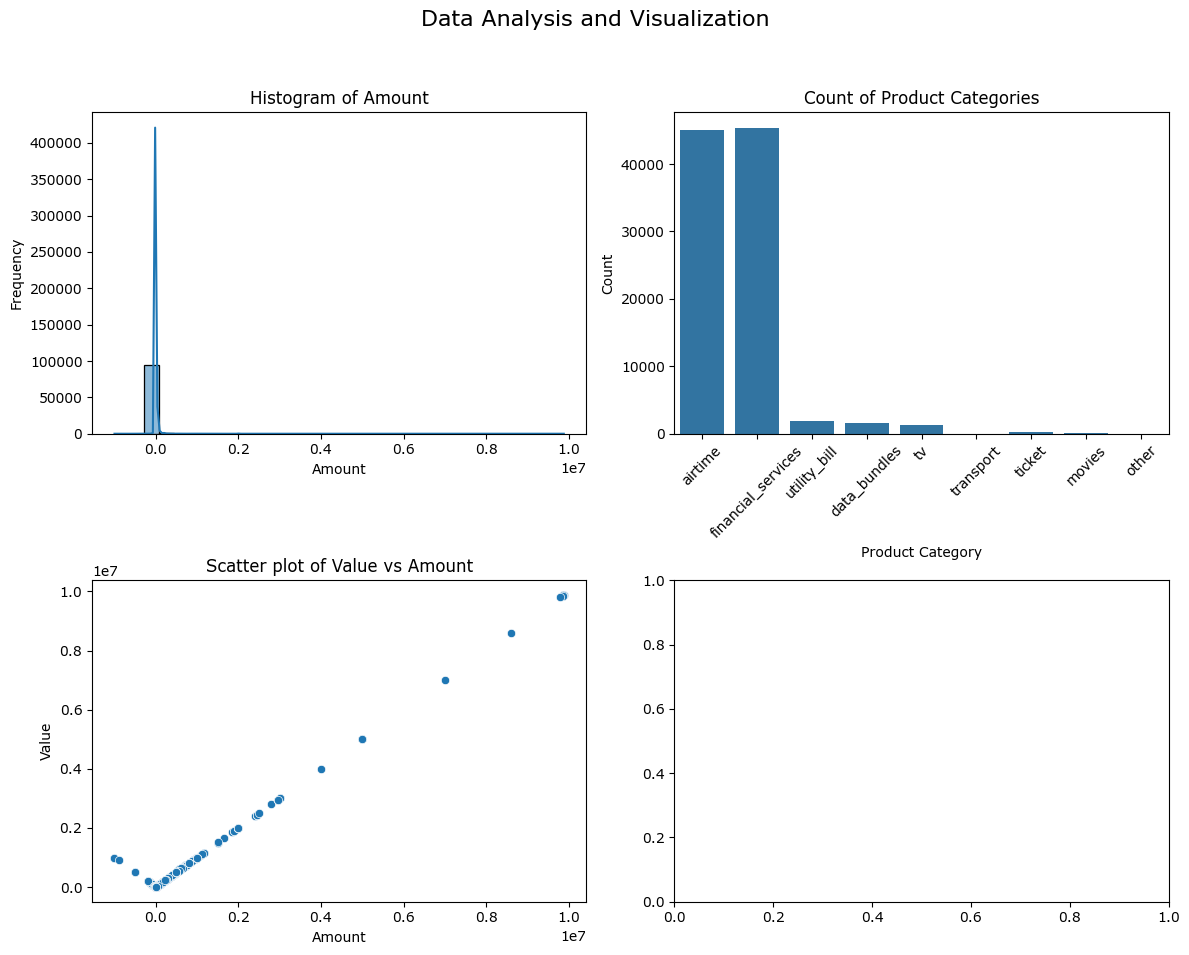

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Data Analysis and Visualization', fontsize=16)

# Example 1: Histogram for the 'Amount' column
sns.histplot(df['Amount'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Histogram of Amount')
axs[0, 0].set_xlabel('Amount')
axs[0, 0].set_ylabel('Frequency')

# Example 2: Bar plot for the 'ProductCategory' column
sns.countplot(data=df, x='ProductCategory', ax=axs[0, 1])
axs[0, 1].set_title('Count of Product Categories')
axs[0, 1].set_xlabel('Product Category')
axs[0, 1].set_ylabel('Count')
axs[0, 1].tick_params(axis='x', rotation=45)

# Example 3: Scatter plot for 'Amount' vs 'Value'
sns.scatterplot(data=df, x='Amount', y='Value', ax=axs[1, 0])
axs[1, 0].set_title('Scatter plot of Value vs Amount')
axs[1, 0].set_xlabel('Amount')
axs[1, 0].set_ylabel('Value')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

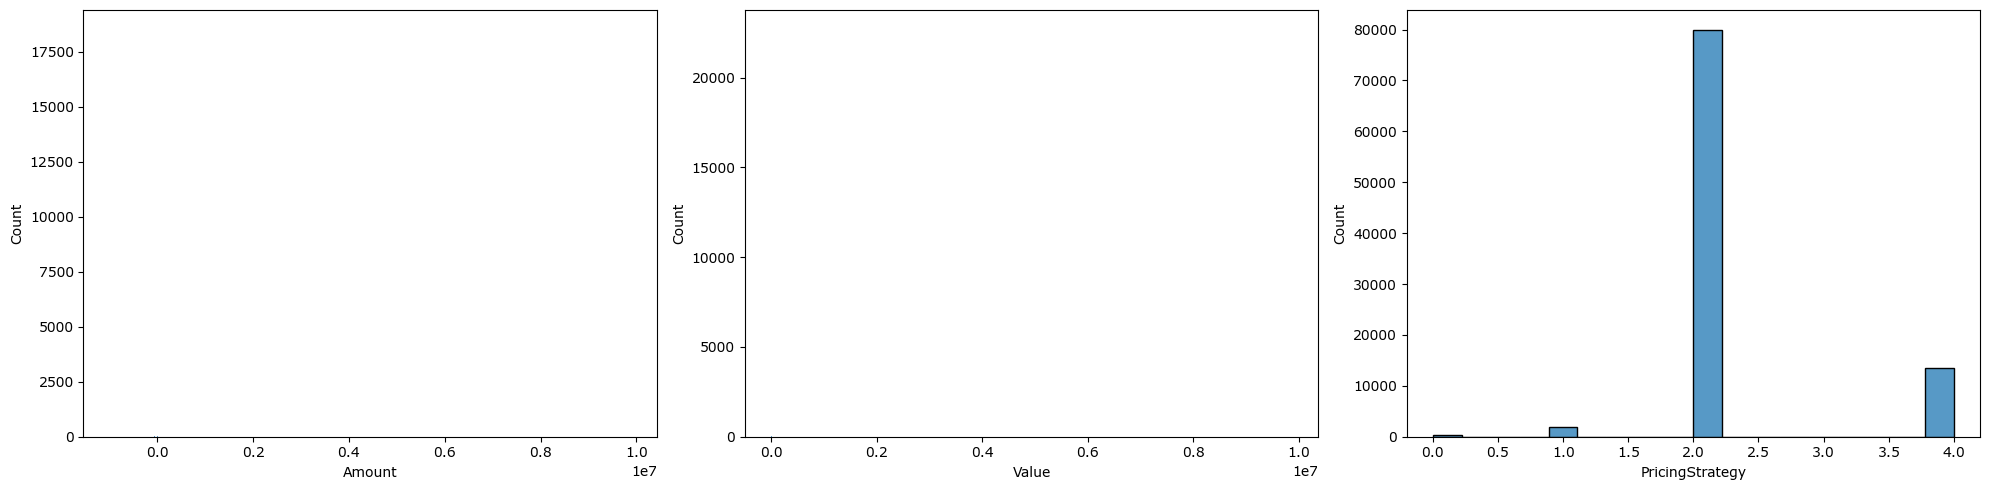

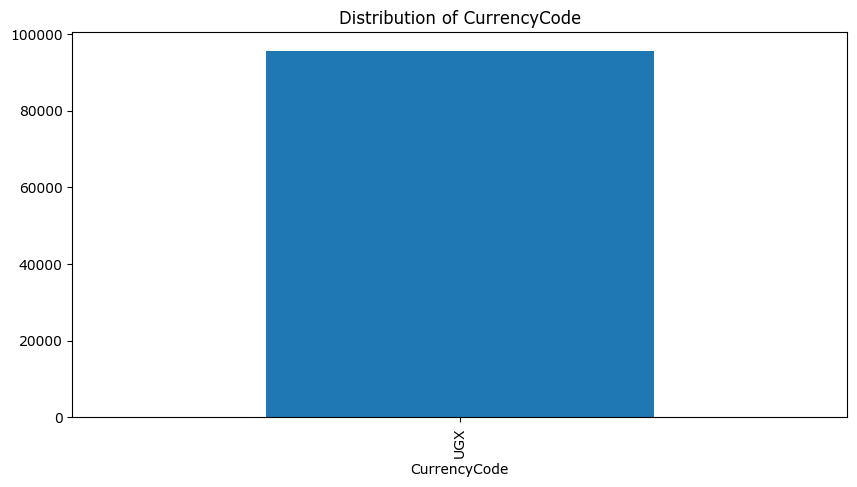

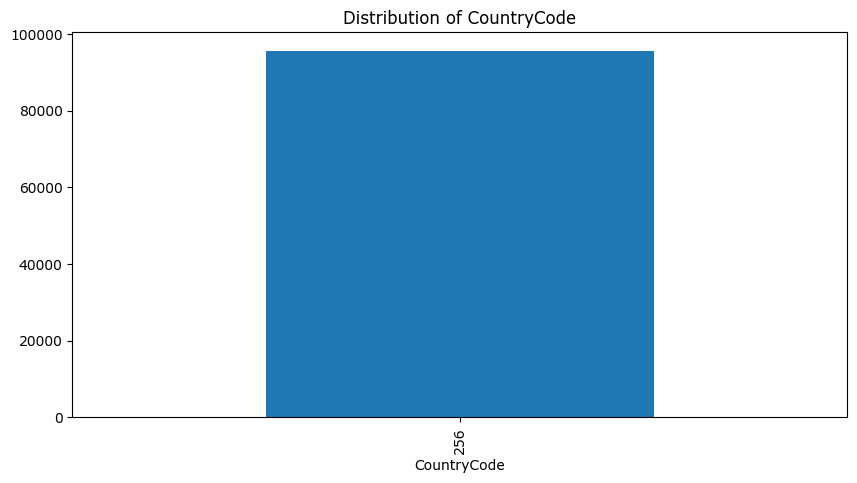

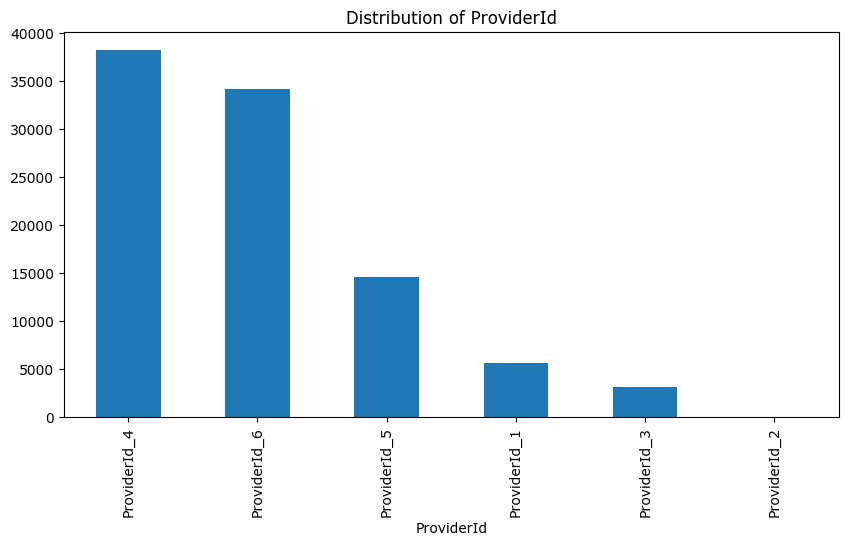

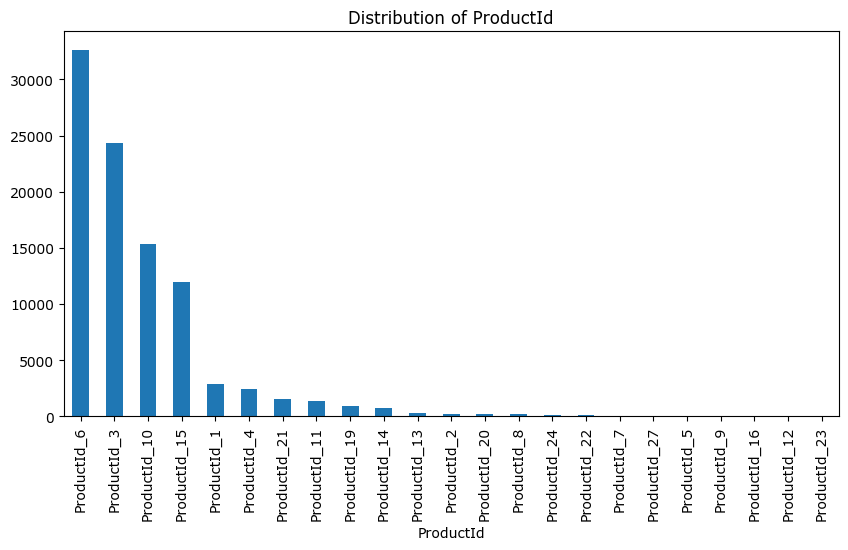

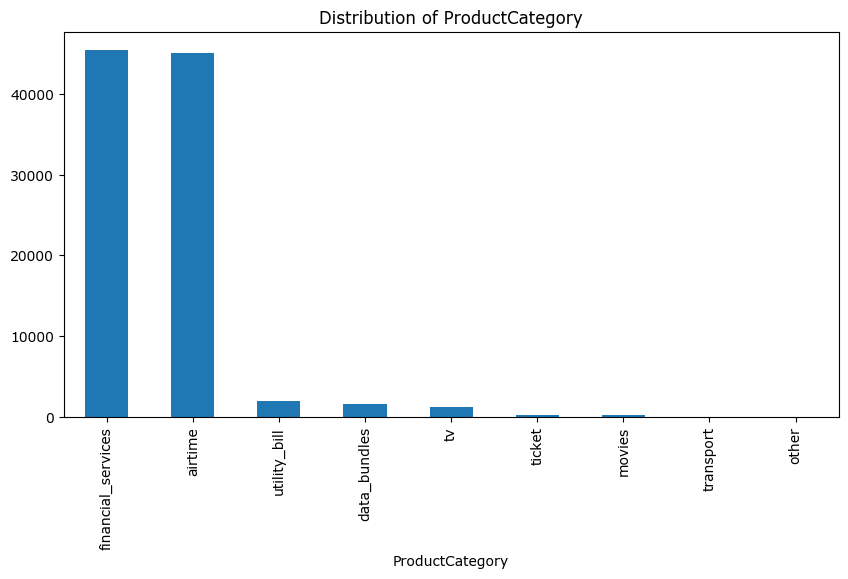

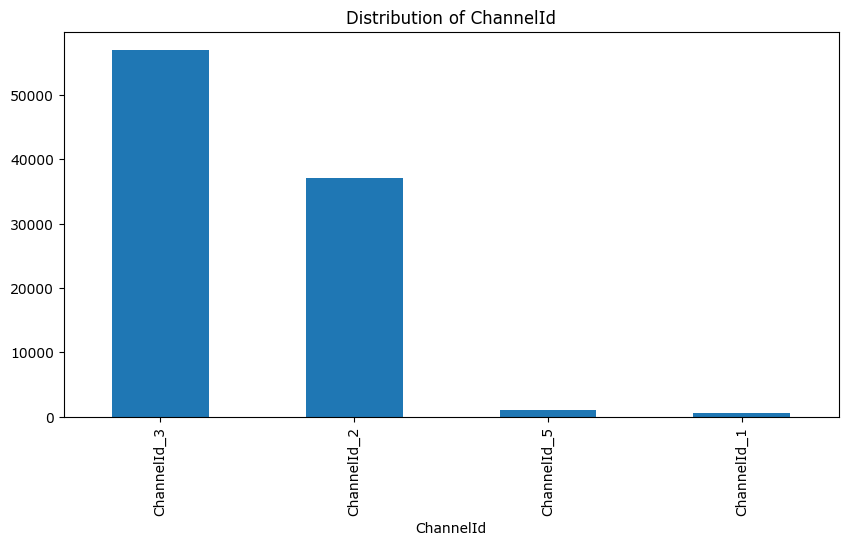

In [12]:
# Distribution of numerical features
numerical_cols = ['Amount', 'Value', 'PricingStrategy']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axes[i])
plt.tight_layout()
plt.show()

# Distribution of categorical features
categorical_cols = ['CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.show()

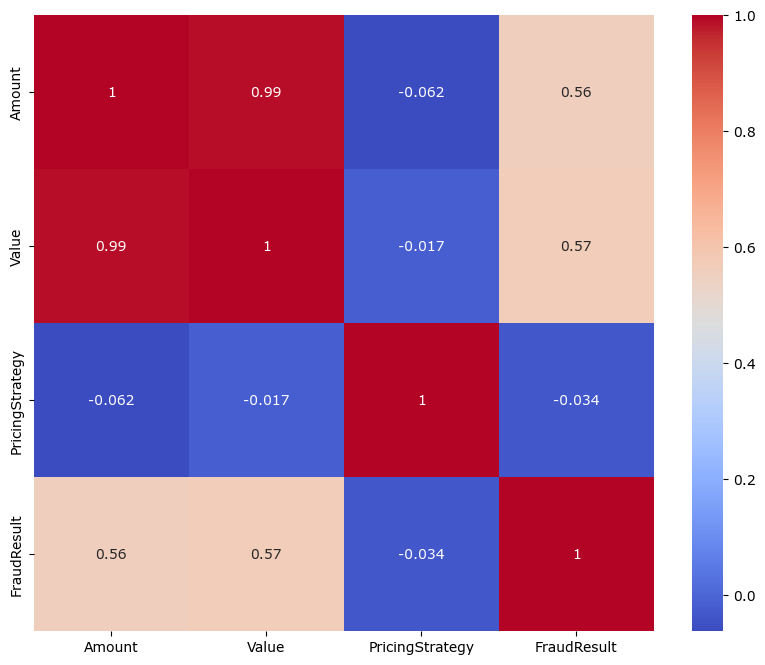

In [13]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols + ['FraudResult']].corr(), annot=True, cmap='coolwarm')
plt.show()

## Feature Engineering

In [18]:
# Ensure TransactionStartTime is in datetime format
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], format='%Y-%m-%dT%H:%M:%SZ')

# Time difference between transactions for each customer
df['prev_transaction'] = df.groupby('CustomerId')['TransactionStartTime'].shift(1)

# Calculate time difference (make sure prev_transaction is also datetime)
df['time_since_last_transaction'] = (df['TransactionStartTime'] - df['prev_transaction']).dt.total_seconds()

# Transaction frequency calculation
df['transaction_frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count') / \
                              ((df.groupby('CustomerId')['TransactionStartTime'].transform('max') - 
                                df.groupby('CustomerId')['TransactionStartTime'].transform('min')).dt.total_seconds() / 86400)


In [19]:
# Calculate avg_amount for each customer
df['avg_amount'] = df.groupby('CustomerId')['Amount'].transform('mean')

# Amount ratio (transaction amount / average amount for that customer)
df['amount_ratio'] = df['Amount'] / df['avg_amount']

# Categorical encoding using mean target encoding
categorical_cols = ['CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']

for col in categorical_cols:
    # Mean target encoding for FraudResult
    df[f'{col}_target_mean'] = df.groupby(col)['FraudResult'].transform('mean')


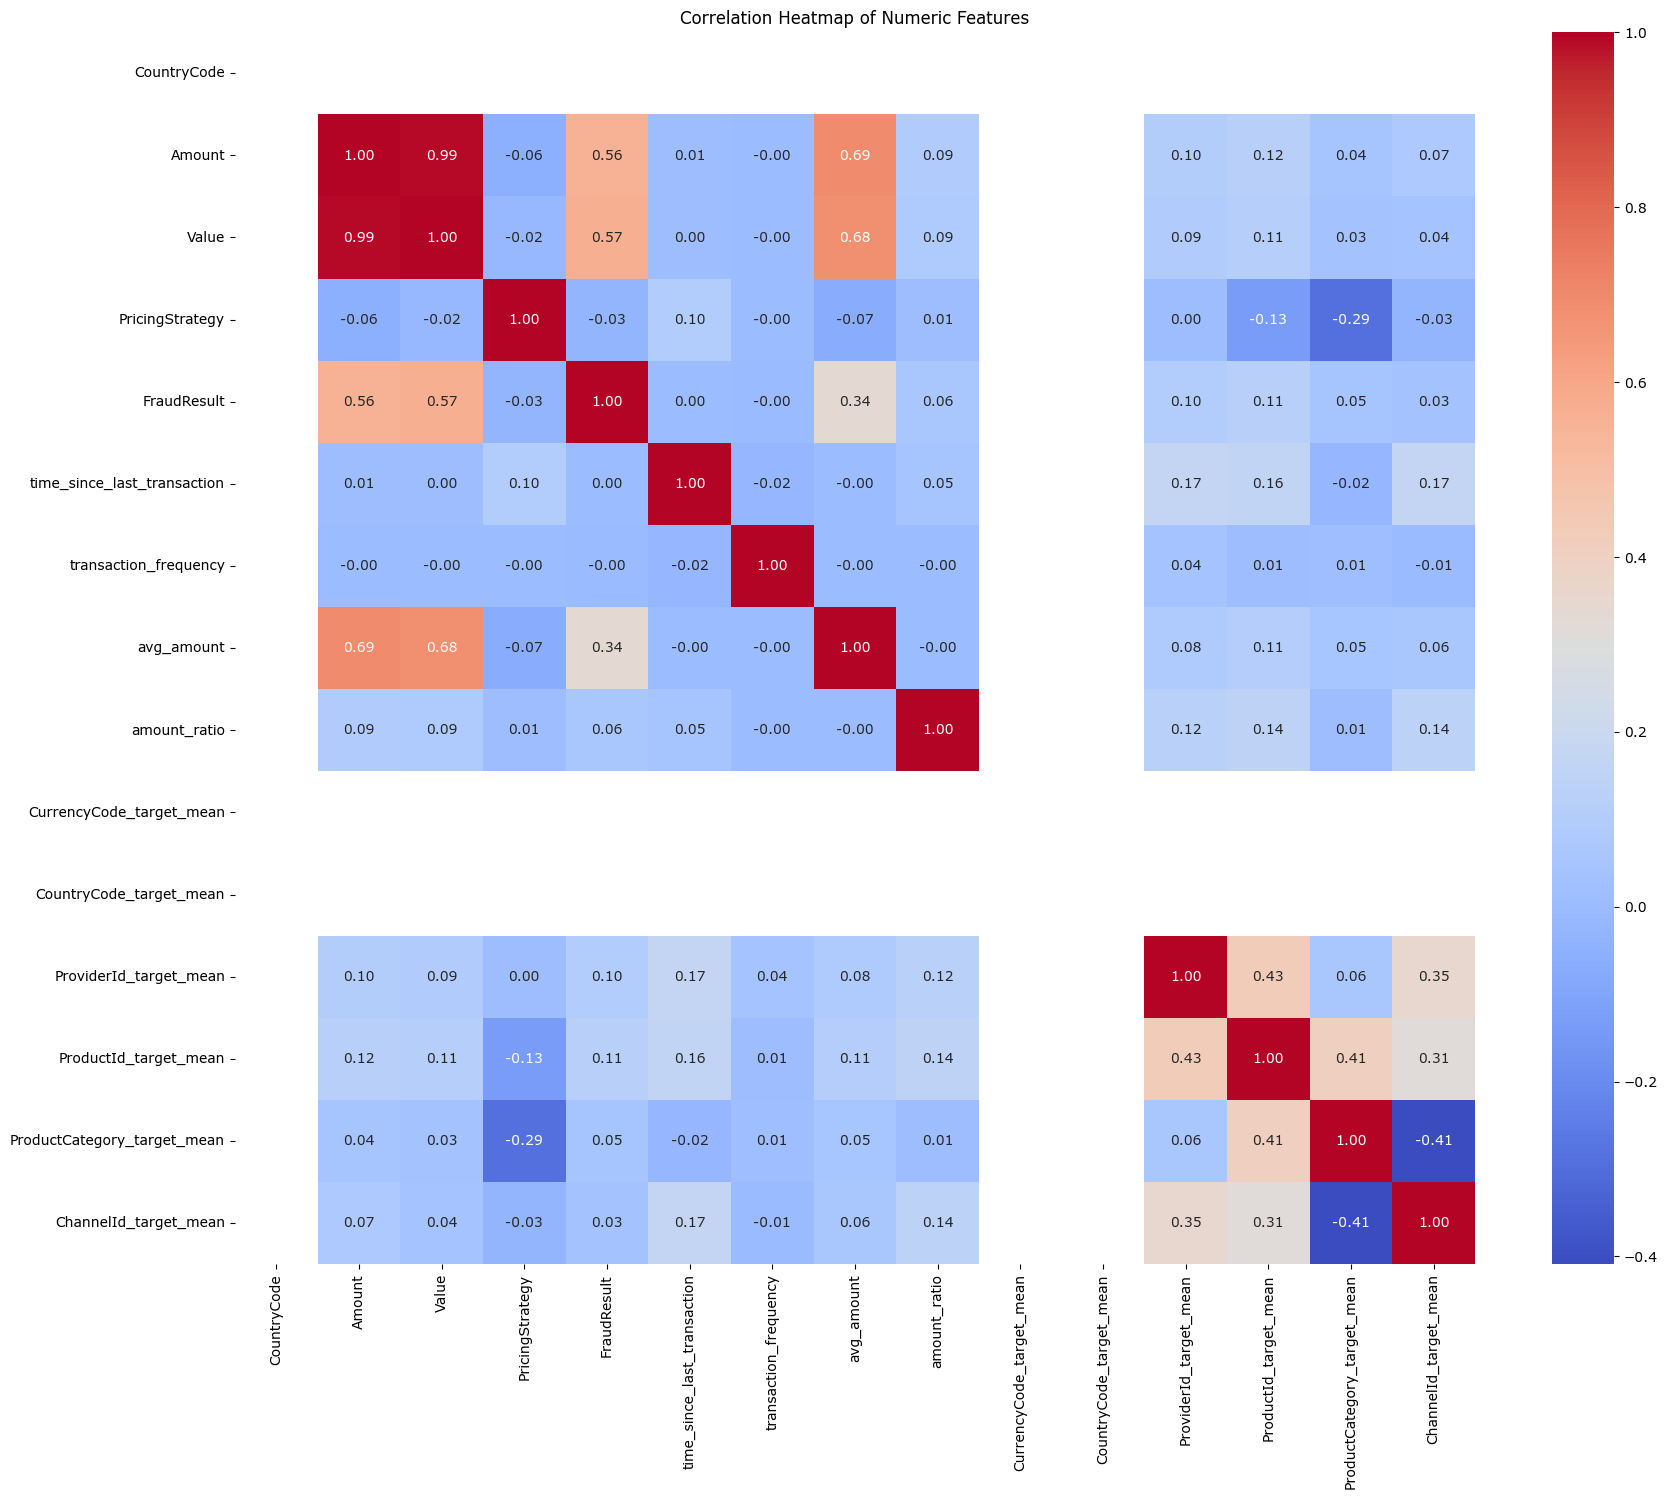

In [21]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [23]:
# Split data into training and testing sets
X = df.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 
             'TransactionStartTime', 'FraudResult', 'prev_transaction'], axis=1)
y = df['FraudResult']


In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Imputers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Use mean for numeric columns
    ('scaler', StandardScaler())                 # Scale the numeric columns
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most frequent value for categorical columns
    ('encoder', LabelEncoder())  # Encode categorical columns (can also use OneHotEncoder)
])

# Create a column transformer to apply the correct transformers to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Now you can proceed with train/test split and model training
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)


c:\Users\doff n\Desktop\doffneri\week_6_EDA\venv\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').